In [1]:
import stim
import stimcirq

In [3]:
circuit_noisy = stim.Circuit.from_file("./surface_code_bZ_d3_r01_center_3_5/circuit_noisy.stim")

detector_error_model_no_decompose_errors = circuit_noisy.detector_error_model()


In [5]:
# circuit_noisy.diagram('timeline-svg')

In [6]:
# surface_code_circuit.without_noise().diagram("timeline-3d")

## 离线生成错误分布

In [3]:
def get_detector_val(targets_copy):
    target_val = []
    for target in targets_copy:
        if target.is_relative_detector_id():
            target_val.append(target.val)
    return target_val
def get_logical_observable_val(targets_copy):
    target_val = []
    for target in targets_copy:
        if target.is_logical_observable_id():
            target_val.append(target.val)
    return target_val

def get_flip_index(detector_val, logical_observable_val, detector_number):
    flip_index = []
    for detector in detector_val:
        if detector not in flip_index:
            flip_index.append(detector)
        else:
            flip_index.remove(detector)
    for logical_observable in logical_observable_val:
        logical_observable = logical_observable+detector_number
        if logical_observable not in flip_index:
            flip_index.append(logical_observable)
        else:
            flip_index.remove(logical_observable)
    return flip_index

def flip_detector_even_str_by_flip_index(detector_even_str, flip_index):
    flip_detector_even_str = detector_even_str
    
    for i in flip_index:
        if detector_even_str[i] == '0':
            flip_detector_even_str = flip_detector_even_str[:i]+'1'+flip_detector_even_str[i+1:]
        else:
            flip_detector_even_str = flip_detector_even_str[:i]+'0'+flip_detector_even_str[i+1:]
    
    return flip_detector_even_str
def get_error_model(detector_error_model, detector_number):
    # detector_number = 8
    
    initial_detector_even_str = '0'*(detector_number+1)
    look_up_table = {}
    look_up_table[initial_detector_even_str] = 1
    for error in detector_error_model:
        if error.type == "error":
            probability = error.args_copy()[0]
            targets_copy = error.targets_copy()
            detector_val = get_detector_val(targets_copy)
            logical_observable_val = get_logical_observable_val(targets_copy)
            flip_index = get_flip_index(detector_val, logical_observable_val, detector_number)
            
            table = {}
            for detector_even_str, detector_even_probability in look_up_table.items():
                no_flip_detector_even_str = detector_even_str
                no_flip_probability = detector_even_probability * (1-probability)
                
                flip_detector_even_str = flip_detector_even_str_by_flip_index(detector_even_str, flip_index)
                flip_probability = detector_even_probability * probability
                
                table[no_flip_detector_even_str] = table.get(no_flip_detector_even_str, 0) + no_flip_probability
                table[flip_detector_even_str] = table.get(flip_detector_even_str, 0) + flip_probability
            look_up_table = table
    return look_up_table

error_model = get_error_model(detector_error_model=detector_error_model_no_decompose_errors, detector_number=detector_error_model_no_decompose_errors.num_detectors)

In [4]:
error_model["110010100"]

2.103472762793859e-06

In [5]:
error_model["110010101"]

1.0112813868790154e-06

## 考虑在线生成错误分布

In [6]:
syndrome_str = "11001010"

In [7]:
detector_error_model_no_decompose_errors

stim.DetectorErrorModel('''
    error(0.009889) D0 D2
    error(0.00341035) D0 D3
    error(0.0329122) D0 D4
    error(0.00433956) D0 D5
    error(0.00921673) D0 D7
    error(0.0145061) D0 L0
    error(0.00400415) D1 D3
    error(0.0299506) D1 D5
    error(0.00278521) D1 L0
    error(0.00965131) D2
    error(0.00488075) D2 D4
    error(0.0252629) D2 D6
    error(0.00467753) D2 D7
    error(0.0176977) D3
    error(0.00325365) D3 D5
    error(0.0357146) D3 D7
    error(0.0139548) D4 D6
    error(0.0160334) D4 D7
    error(0.0626966) D4 L0
    error(0.0226447) D5 D7
    error(0.0197193) D5 L0
    error(0.0108271) D6
    error(0.0564801) D7
    detector(2, 5, 0) D0
    detector(4, 3, 0) D1
    detector(2, 7, 0) D2
    detector(4, 5, 0) D3
    detector(2, 5, 1) D4
    detector(4, 3, 1) D5
    detector(2, 7, 1) D6
    detector(4, 5, 1) D7
''')

In [8]:
detector_error_model = detector_error_model_no_decompose_errors
detector_number = detector_error_model_no_decompose_errors.num_detectors

def get_detector_error_model_dict(detector_error_model, detector_number):
    detector_error_model_dict = {}

    for error in detector_error_model:
        if error.type == "error":
            probability = error.args_copy()[0]
            targets_copy = error.targets_copy()
            detector_val = get_detector_val(targets_copy)
            logical_observable_val = get_logical_observable_val(targets_copy)
            flip_index = get_flip_index(detector_val, logical_observable_val, detector_number)
            
            detector_error_model_dict[tuple(flip_index)] = probability
            
    return detector_error_model_dict

In [9]:
detector_error_model_dict = get_detector_error_model_dict(detector_error_model, detector_number)

In [126]:
def get_related_error_model(syndrome_str, detector_error_model_dict, detector_number):
    initial_detector_even_str = '0'*(detector_number+1)
    error_table= {}
    error_table[initial_detector_even_str] = 1
    
    # 通过一个table来记录当前错误经过的错误事件
    pass_error_even = []
    
    for i in range(detector_number):
        detector_i = syndrome_str[i]
        related_detector_error_model_dict = {k:v for k,v in detector_error_model_dict.items() if i == k[0]}
        print(f"related error even list:{related_detector_error_model_dict}")
        print(f"related error even number: {len(related_detector_error_model_dict)}")
        for flip_detector, probability in related_detector_error_model_dict.items():        
            table = {}
            for detector_even_str, detector_even_probability in error_table.items():
                no_flip_detector_even_str = detector_even_str
                no_flip_probability = detector_even_probability * (1-probability)
                
                flip_detector_even_str = flip_detector_even_str_by_flip_index(detector_even_str, flip_detector)
                flip_probability = detector_even_probability * probability
                # 不同的错误机制组合，引发出现相同的错误情况。因此，需要将概率相加。
                table[no_flip_detector_even_str] = table.get(no_flip_detector_even_str, 0) + no_flip_probability
                table[flip_detector_even_str] = table.get(flip_detector_even_str, 0) + flip_probability
            # 只有当flip_detector_even_str[i] == detector_i时，才会放入到error_table。
            # print(table)
            error_table = table
        # {k:v for k,v in table.items() if detector_i == k[i]
        error_table = {k:v for k,v in error_table.items() if detector_i == k[i]}
        # print(error_table)
        print(f"Possible error table len:{len(error_table)}")
    return error_table

In [127]:
error_table = get_related_error_model(syndrome_str=syndrome_str, detector_error_model_dict=detector_error_model_dict, detector_number=detector_number)

related error even list:{(0, 2): 0.009889001998225533, (0, 3): 0.003410349649973194, (0, 4): 0.03291221673144394, (0, 5): 0.0043395649378285195, (0, 7): 0.009216729243890904, (0, 8): 0.014506104219003545}
related error even number: 6
Possible error table len:32
related error even list:{(1, 3): 0.004004146218508711, (1, 5): 0.029950599650535703, (1, 8): 0.0027852058693198104}
related error even number: 3
Possible error table len:32
related error even list:{(2,): 0.009651310857700426, (2, 4): 0.00488074518652898, (2, 6): 0.025262914381168376, (2, 7): 0.004677532145399821}
related error even number: 4
Possible error table len:64
related error even list:{(3,): 0.01769771795187231, (3, 5): 0.0032536475060086544, (3, 7): 0.03571464729963995}
related error even number: 3
Possible error table len:32
related error even list:{(4, 6): 0.013954798892733747, (4, 7): 0.01603336385596291, (4, 8): 0.06269655330856576}
related error even number: 3
Possible error table len:16
related error even list:{(5

基于在线的方法，我们可以看到，在d=3，r=1，8个detector、1个logical qubit的情况下，最高的table为32.

如果S表格table的大小，其中detector的数量为：
$$O(r d^2)$$
则整个在线学习的复杂度为：
$$O(r d^2 S_{max})$$

剩下我们需要去估计$S_{max}$的复杂度。

## 路径跟踪的在线MLD

In [122]:
def get_related_error_model_pass_path(syndrome_str, detector_error_model_dict, detector_number):
    initial_detector_even_str = '0'*(detector_number+1)
    error_table= []
    error_table.append((initial_detector_even_str, 1))
    
    # 通过一个table来记录当前错误经过的错误事件，可能会存在路径不同，但是相同的状态和概率，但这非常小。
    pass_error_even_table = [["start"]]
    
    
    for i in range(detector_number):
        detector_i = syndrome_str[i]
        related_detector_error_model_dict = {k:v for k,v in detector_error_model_dict.items() if i == k[0]}
        # print(f"related error even list:{related_detector_error_model_dict}")
        # print(f"related error even number: {len(related_detector_error_model_dict)}")

        for flip_detector, probability in related_detector_error_model_dict.items():
            # 错误事件，分别作用
            # table = {}
            table = []
            pass_table = []
            for j  in range(len(error_table)):
                # 前一层的所有节点
                error_even = error_table[j]
                # 当前状态
                detector_even_str = error_even[0]
                # 发生概率
                detector_even_probability = error_even[1]
                
                # 当前状态，不发生错误的状态
                no_flip_detector_even_str = detector_even_str
                # 当前状态，不发生错误，当前状态概率
                no_flip_probability = detector_even_probability * (1-probability)
                
                # 当前状态，发生错误之后，翻转状态
                flip_detector_even_str = flip_detector_even_str_by_flip_index(detector_even_str, flip_detector)
                # 发生错误之后，翻转状态概率
                flip_probability = detector_even_probability * probability
                
                # 更新table，先添加不翻转的
                table.append((no_flip_detector_even_str, no_flip_probability))
                table.append((flip_detector_even_str, flip_probability))
                
                # 前一层的pass error even
                pass_error_even = pass_error_even_table[j]
                pass_table.append(pass_error_even+[None])
                pass_table.append(pass_error_even+[flip_detector])    
            # 过滤错误率
            # print("table", table)
            # print("pass_table", pass_table)
            
            error_table = table
            pass_error_even_table = pass_table
            # 只有当flip_detector_even_str[i] == detector_i时，才会放入到error_table。
        table = []
        pass_table = []
        for k in range(len(error_table)):
            detector_even_str, detector_even_probability = error_table[k]
            if detector_even_str[i] == detector_i:
                table.append(error_table[k])
                pass_table.append(pass_error_even_table[k])
        error_table = table
        pass_error_even_table = pass_table
    print(f"Possible error state number:{len(error_table)}")
    print(f"pass error even number:{len(pass_error_even_table)}")
    return error_table, pass_error_even_table

In [123]:
error_table, pass_error_even_table = get_related_error_model_pass_path(syndrome_str=syndrome_str, detector_error_model_dict=detector_error_model_dict, detector_number=detector_number)

Possible error state number:32768
pass error even number:32768


### 根据路径实现的好坏：
1. 跟踪路径，我们可以得到当前的状态，是由那些错误组合而成的。
2. MWPM主要是寻找一个最大的概率路径。而解码，理论上不是找到最大路径，而是找到所有可能造成这个syndrome的路径之和。（Points worth debating）

劣势：
1. 如果需要跟踪路径的话，可能会造成规模较大。同一个table下，理论上有很多的重复，可以先进行合并。

和生成所有的错误状态的结果一致。

In [111]:
p_0 = 0
p_1 = 0
n = 0
error_table_0 = []

error_table_1 = []
#--------------
max_0 = 0
max_1 = 0
max_path_0 = []
max_path_1 = []

#----------------
values_0 = []
values_1 = []
for i in range(len(error_table)):
    if error_table[i][0][-1] == '1':
        # print(error_table[i], pass_error_even_table[i])
        p_1 += error_table[i][1]
        n += 1
        error_table_1.append((error_table[i], pass_error_even_table[i]))
        if error_table[i][1] > max_1:
            max_1 = error_table[i][1]
            max_path_1 = pass_error_even_table[i]
        values_1.append(error_table[i][1])
    else:
        # print(error_table[i], pass_error_even_table[i])
        print(error_table[i])
        p_0 += error_table[i][1]
        # n += 1
        if error_table[i][1] > max_1:
            max_0 = error_table[i][1]
            max_path_0 = pass_error_even_table[i]
        error_table_0.append((error_table[i], pass_error_even_table[i]))
        values_0.append(error_table[i][1])
# print(p)
print(n)

('110010100', 5.509998783372808e-13)
('110010100', 2.8798925413572664e-10)
('110010100', 3.817472003160743e-07)
('110010100', 1.939276040115414e-13)
('110010100', 2.8751709944458835e-15)
('110010100', 8.067099055404867e-16)
('110010100', 1.0693428434735526e-12)
('110010100', 1.011933112869156e-15)
('110010100', 6.142148731798663e-15)
('110010100', 3.21029622982716e-12)
('110010100', 1.524870136831689e-11)
('110010100', 7.746341343687097e-18)
('110010100', 2.336419987791697e-14)
('110010100', 6.555481921928595e-15)
('110010100', 3.113811903840137e-14)
('110010100', 2.94664091313004e-17)
('110010100', 1.0242772605278861e-13)
('110010100', 5.3535555248715707e-11)
('110010100', 3.046545713873154e-14)
('110010100', 1.547645432144311e-20)
('110010100', 5.344778439202441e-16)
('110010100', 1.4996275762912674e-16)
('110010100', 8.533924685624226e-20)
('110010100', 8.075764498561626e-23)
('110010100', 4.091424390595533e-18)
('110010100', 2.138451032250626e-15)
('110010100', 3.3960691514669186e-

In [116]:
print(max_0, max_path_0)
print(max_0 / p_0)

1.2495597551363571e-06 ['start', None, None, None, (0, 5), None, None, None, (1, 5), None, None, None, None, None, None, None, None, (4, 6), None, None, None, None, None, None]
0.5940460828581052


In [117]:
print(max_1, max_path_1)
print(max_1 / p_1)

6.826251790022299e-07 ['start', None, None, (0, 4), None, None, None, None, None, (1, 8), None, None, None, None, None, None, None, None, None, None, None, None, (6,), None]
0.6750101285943335


会不会：出错最大路径的概率>不出错最大路径的概率 != 在某个syndrome下，出错的概率>不出错的概率？

这个关系可能不是等价的。

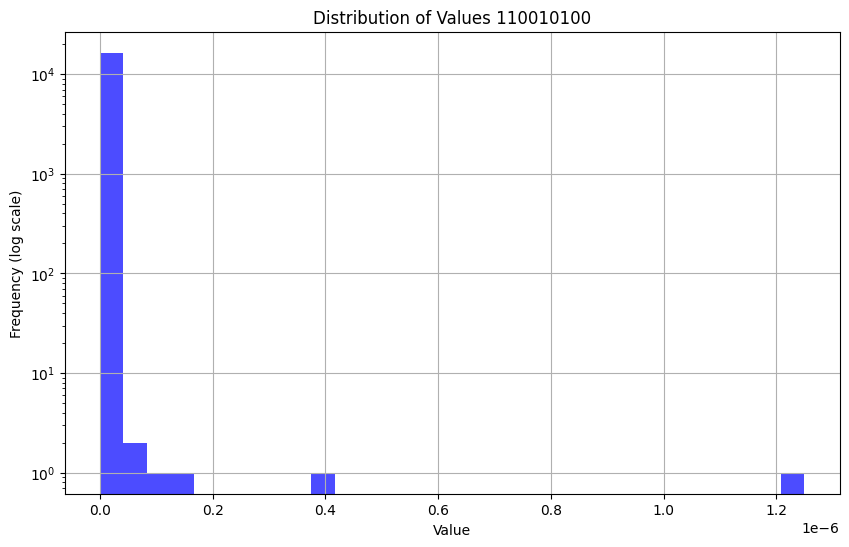

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# 提供的数值
values = values_0

# 绘制分布图
plt.figure(figsize=(10, 6))
plt.hist(values, bins=30, color='blue', alpha=0.7)
plt.yscale('log')  # 使用对数刻度
plt.title('Distribution of Values 110010100')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


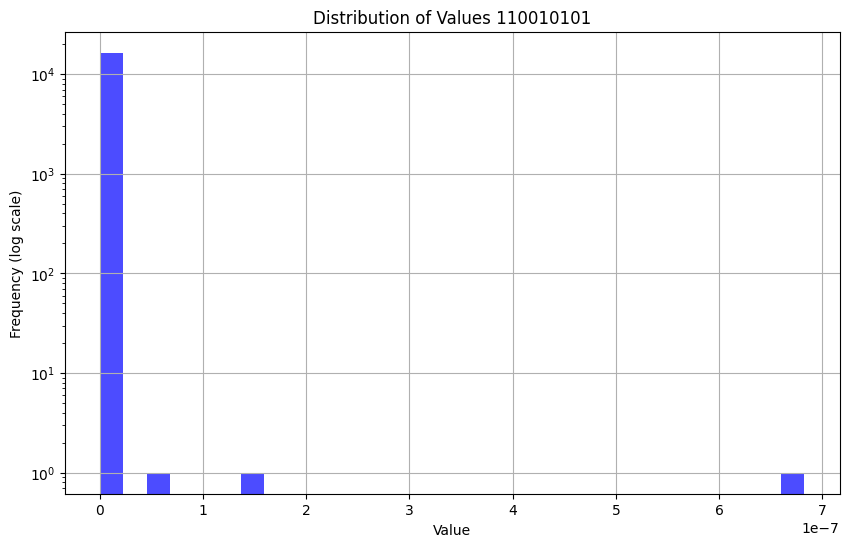

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# 提供的数值
values = values_1

# 绘制分布图
plt.figure(figsize=(10, 6))
plt.hist(values, bins=30, color='blue', alpha=0.7)
plt.yscale('log')  # 使用对数刻度
plt.title('Distribution of Values 110010101')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


In [128]:
edge = [(0,
  2,
  {'fault_ids': set(),
   'weight': 4.606393825684147,
   'error_probability': 0.009889001998225533}),
 (0,
  3,
  {'fault_ids': set(),
   'weight': 5.677524278146614,
   'error_probability': 0.003410349649973194}),
 (0,
  4,
  {'fault_ids': set(),
   'weight': 3.502310820062799,
   'error_probability': 0.02924655239883901}),
 (0,
  5,
  {'fault_ids': set(),
   'weight': 5.950486511610318,
   'error_probability': 0.002597806877289565}),
 (0,
  7,
  {'fault_ids': set(),
   'weight': 4.6774755840411775,
   'error_probability': 0.009216729243890904}),
 (0,
  None,
  {'fault_ids': {0},
   'weight': 3.8931798504785204,
   'error_probability': 0.01997337015593154}),
 (1,
  3,
  {'fault_ids': set(),
   'weight': 5.516412715810672,
   'error_probability': 0.004004146218508711}),
 (1,
  5,
  {'fault_ids': set(),
   'weight': 3.536354308222315,
   'error_probability': 0.02829535307513715}),
 (1,
  None,
  {'fault_ids': {0},
   'weight': 5.392499824264326,
   'error_probability': 0.004529969442432108}),
 (2,
  None,
  {'fault_ids': set(),
   'weight': 4.2988278907904425,
   'error_probability': 0.013402407537146253}),
 (2,
  4,
  {'fault_ids': set(),
   'weight': 5.317564673695711,
   'error_probability': 0.00488074518652898}),
 (2,
  6,
  {'fault_ids': set(),
   'weight': 3.713541480684945,
   'error_probability': 0.02381023471942101}),
 (2,
  7,
  {'fault_ids': set(),
   'weight': 6.037483916785727,
   'error_probability': 0.002381871800146516}),
 (3,
  None,
  {'fault_ids': set(),
   'weight': 3.9036554601964273,
   'error_probability': 0.019769343844897622}),
 (3,
  5,
  {'fault_ids': set(),
   'weight': 5.72471965029148,
   'error_probability': 0.003253647506008654}),
 (3,
  7,
  {'fault_ids': set(),
   'weight': 3.3556140098747953,
   'error_probability': 0.03371180648537959}),
 (4,
  6,
  {'fault_ids': set(),
   'weight': 4.257878740701624,
   'error_probability': 0.01395479889273375}),
 (4,
  7,
  {'fault_ids': set(),
   'weight': 4.1169201979796295,
   'error_probability': 0.01603336385596291}),
 (4,
  None,
  {'fault_ids': {0},
   'weight': 2.6481722856818486,
   'error_probability': 0.06610174907554424}),
 (5,
  7,
  {'fault_ids': set(),
   'weight': 3.7649235774399297,
   'error_probability': 0.02264471867511021}),
 (5,
  None,
  {'fault_ids': {0},
   'weight': 3.7454132106190983,
   'error_probability': 0.023080566240058692}),
 (6,
  None,
  {'fault_ids': set(),
   'weight': 4.384187488455677,
   'error_probability': 0.012319358898452896}),
 (7,
  None,
  {'fault_ids': set(),
   'weight': 2.7440703768480397,
   'error_probability': 0.06042240786879905})]

In [140]:
p = 1
flip_list = [(0, 4), (6, None), (1, None)]
no_flip_list = [(0, 5), (1, 5), (4, 6)]

for i in range(len(edge)):
    if (edge[i][0], edge[i][1]) in flip_list:
        p = p * edge[i][2]['error_probability']
        print(edge[i])
    # else:
    #     p = p * (1 - edge[i][2]['error_probability'])
print(p)

p = 1
for i in range(len(edge)):
    if (edge[i][0], edge[i][1]) in no_flip_list:
        p = p * edge[i][2]['error_probability']
        print(edge[i])
    # else:
    #     p = p * (1 - edge[i][2]['error_probability'])
print(p)

(0, 4, {'fault_ids': set(), 'weight': 3.502310820062799, 'error_probability': 0.02924655239883901})
(1, None, {'fault_ids': {0}, 'weight': 5.392499824264326, 'error_probability': 0.004529969442432108})
(6, None, {'fault_ids': set(), 'weight': 4.384187488455677, 'error_probability': 0.012319358898452896})
1.6321424433586944e-06
(0, 5, {'fault_ids': set(), 'weight': 5.950486511610318, 'error_probability': 0.002597806877289565})
(1, 5, {'fault_ids': set(), 'weight': 3.536354308222315, 'error_probability': 0.02829535307513715})
(4, 6, {'fault_ids': set(), 'weight': 4.257878740701624, 'error_probability': 0.01395479889273375})
1.0257595330052375e-06
